In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gibbs_sampling import *
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv('Data/macro1.csv')
df.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,Transform:,5.0,5.0,5.000,5.000000,5.00000,5.0000,5.0000,5.0000,5.0000,...,6.000,6.00,6.00,6.00,2.0,6.0,6.0,6.0,6.0,1.0
1,01/01/1959,2289.8,2151.9,18.191,253747.578885,18234.44037,21.9289,21.5499,20.9407,28.4830,...,12.133,2.13,2.45,2.04,NaN,274.9,6476.0,12298.0,84.2,NaN
2,02/01/1959,2299.6,2160.2,18.380,255653.461901,18368.21974,22.3584,21.8408,21.1221,28.6919,...,12.149,2.13,2.46,2.05,NaN,276.0,6476.0,12298.0,83.5,NaN
3,03/01/1959,2314.4,2176.1,18.555,254743.765035,18521.70306,22.6805,21.9730,21.2257,28.6919,...,12.169,2.15,2.45,2.07,NaN,277.4,6508.0,12349.0,81.6,NaN
4,04/01/1959,2328.5,2190.3,18.488,259878.438046,18533.11060,23.1636,22.2903,21.5367,29.1445,...,12.211,2.16,2.47,2.08,NaN,278.1,6620.0,12484.0,81.8,NaN


In [4]:
# We remove the first row
df = df.iloc[1:]

In [5]:
df.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
1,01/01/1959,2289.8,2151.9,18.191,253747.578885,18234.44037,21.9289,21.5499,20.9407,28.4830,...,12.133,2.13,2.45,2.04,NaN,274.9,6476.0,12298.0,84.2,NaN
2,02/01/1959,2299.6,2160.2,18.380,255653.461901,18368.21974,22.3584,21.8408,21.1221,28.6919,...,12.149,2.13,2.46,2.05,NaN,276.0,6476.0,12298.0,83.5,NaN
3,03/01/1959,2314.4,2176.1,18.555,254743.765035,18521.70306,22.6805,21.9730,21.2257,28.6919,...,12.169,2.15,2.45,2.07,NaN,277.4,6508.0,12349.0,81.6,NaN
4,04/01/1959,2328.5,2190.3,18.488,259878.438046,18533.11060,23.1636,22.2903,21.5367,29.1445,...,12.211,2.16,2.47,2.08,NaN,278.1,6620.0,12484.0,81.8,NaN
5,05/01/1959,2342.5,2205.6,18.710,261691.222172,18678.29753,23.5125,22.4754,21.7441,29.2838,...,12.230,2.17,2.48,2.08,95.3,280.1,6753.0,12646.0,80.7,NaN


In [6]:
# We remove the features in which there are a lot of Nan values
pd.DataFrame(df.isna().sum()).sort_values(0, ascending=False).iloc[:10]

,0
ACOGNO,398
TWEXMMTH,168
UMCSENTx,154
ANDENOx,109
VXOCLSx,42
PERMITW,12
PERMITS,12
PERMITMW,12
PERMITNE,12
PERMIT,12


In [7]:
columns_to_drop = ['ACOGNO', 'TWEXMMTH', 'UMCSENTx', 'ANDENOx', 'VXOCLSx']
df = df.drop(columns_to_drop,axis=1)

In [8]:
# We remove the remaining NaN values
df = df.dropna()

In [9]:
#We reorder the columns
columns = df.columns.tolist()
new_column_order = ['INDPRO'] + [column for column in columns if column not in ['sasdate', 'INDPRO']]
df = df[new_column_order]

In [10]:
df.head()

,INDPRO,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST
13,24.1298,2391.2,2252.3,18.910,263212.787497,18762.29853,23.3215,22.6512,30.5722,20.1768,...,54.611,20.000,12.502,2.22,2.57,2.13,286.7,7362.0,14063.0,75.5
14,23.9151,2392.8,2253.8,18.993,267039.890455,18831.78084,23.1893,22.5734,30.2240,19.8991,...,54.700,20.001,12.522,2.23,2.59,2.14,287.0,7396.0,14144.0,73.3
15,23.7004,2397.2,2255.4,19.262,259610.179810,18811.03986,23.1100,22.5475,30.2588,19.5057,...,54.540,20.037,12.529,2.24,2.69,2.14,287.8,7456.0,14239.0,71.5
16,23.5125,2405.6,2263.4,19.560,262179.545533,19304.67539,23.1629,22.5734,30.4677,19.4826,...,54.606,20.163,12.555,2.24,2.61,2.14,288.3,7582.0,14413.0,71.5
17,23.4857,2411.7,2269.4,19.166,254056.886617,19016.37565,23.2951,22.7289,30.6418,19.6677,...,54.600,20.154,12.590,2.24,2.64,2.14,289.1,7673.0,14559.0,71.7


In [11]:
num_predictors = len(df.columns) - 1
num_predictors

120

In [12]:
# We initialize the parameters for the Gibbs
a, b, A, B = 1, 1, 1, 1 # Parameters for Beta laws
q = np.random.beta(a, b, 1)[0]
R_2 = np.random.beta(A, B, 1)[0]

start = np.arange(0, 0.1 + 0.001, 0.001)[1:]
mid = np.arange(0.11, 0.9 + 0.01, 0.01)
end = np.arange(0.901, 1 + 0.001, 0.001)[:-1]
support = np.concatenate((start, mid, end))

In [13]:
# We define the outcome y and the predictors X
X = df.drop(['INDPRO'], axis=1)
y = df['INDPRO']

C:\Users\bapti\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.096e+01, tolerance: 2.971e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\bapti\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.231e+01, tolerance: 2.971e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\bapti\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

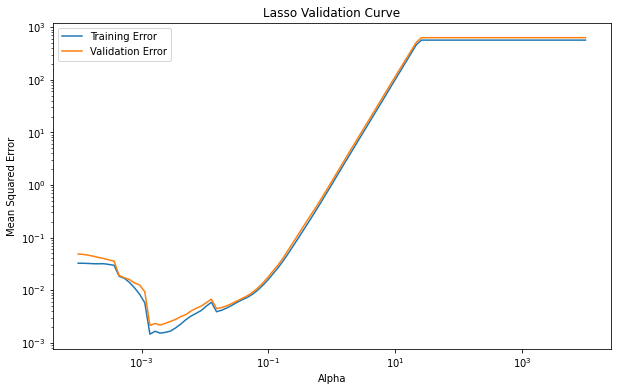

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.fit_transform(X)
alphas = np.logspace(-4, 4, 100)
train_errors = []
validation_errors = []

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha,max_iter=10000)
    lasso_model.fit(X_train_scaled, y_train)  # Supposons que X_train et y_train soient vos données d'entraînement
    y_pred_train = lasso_model.predict(X_train_scaled)
    y_pred_validation = lasso_model.predict(X_test_scaled)  # Supposons que X_validation soit votre ensemble de validation
    
    train_errors.append(mean_squared_error(y_train, y_pred_train))  # Vous pouvez utiliser une autre métrique de performance
    validation_errors.append(mean_squared_error(y_test, y_pred_validation))

# Tracer la courbe de validation
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_errors, label='Training Error')
plt.plot(alphas, validation_errors, label='Validation Error')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')  # Utilisez la métrique de performance appropriée
plt.legend()
plt.title('Lasso Validation Curve')
plt.show()

#$\alpha _{opt}$ = 0.005 : (Train Error , Validation Error) = (0.33548518219396917, 0.32653694179816917)

In [15]:
# Now, we run the Lasso Regression using our best regularization term.
lasso_model = Lasso(alpha=0.005)
lasso_model.fit(X_train_scaled, y_train)
beta_estimates = lasso_model.coef_

C:\Users\bapti\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.151e+02, tolerance: 2.971e+01
  model = cd_fast.enet_coordinate_descent(


In [16]:
y_pred_train = lasso_model.predict(X_train_scaled)
y_pred_validation = lasso_model.predict(X_test_scaled)  # Supposons que X_validation soit votre ensemble de validation
train_error = mean_squared_error(y_train, y_pred_train)
validation_error = mean_squared_error(y_test, y_pred_validation)

In [17]:
train_error , validation_error

(0.12371893270533105, 0.13578030507949632)

In [18]:
z_initial = (np.abs(beta_estimates) > 0).astype(int)

In [19]:
z_initial.sum()

50

In [50]:
my_array = np.array([1]*1+[0]*119)

In [51]:
import random as random
random.shuffle(my_array)
my_array

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [20]:
np.linalg.norm(beta_estimates,ord=1)

47.05484454289537

In [53]:
z_final = sample_z(Y=y, X=X_scaled, q_start=q, R_2_start=R_2, num_iterations=100, z=z_initial, support=support)

c:\Users\bapti\OneDrive\Bureau\GitHub\bayesian_statistics_project\gibbs_sampling.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(lambda x: density_R2(x, z), 10**(-3), r)[0]/quad(lambda x: density_R2(x, z), 10**(-3), 1 - 10**(-3))[0]
c:\Users\bapti\OneDrive\Bureau\GitHub\bayesian_statistics_project\gibbs_sampling.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  p = 1 / (1 + ( ((gamma_2**0.5)*(1-q)) / q ) * (np.linalg.det(W_tilde_inv_0)/np.linalg.det(W_tilde_inv))**(0.5)
c:\Users\bapti\OneDrive\Bureau\GitHub\bayesian_statistics_project\gibbs_sam

In [55]:
z_final

array([1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [74]:
X_tilde = X_scaled[:, z_final == 1]
X_train, X_test, y_train, y_test = train_test_split(X_tilde, y, test_size=0.2)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.030008062118696856
R-squared: 0.9999444783893097


In [82]:
# Obtenez les coefficients beta
coefficients_beta = model.coef_

# Affichez les coefficients sous forme d'array
print("Coefficients beta:", coefficients_beta)

Coefficients beta: [ 1.22037348e+00 -5.79948434e-01 -1.45463977e+00 -1.35191100e+01
  1.00045580e+01 -5.02472270e-01  2.15598742e-01  5.05289107e-01
  2.60708686e+01  1.13378876e+00 -6.28191149e-01  6.53483629e-02
  2.92220122e-01  1.42961071e-01 -2.51445869e-01 -2.98907804e-01
  4.64781345e-01  1.01458023e+00 -9.05551927e-01 -3.96283596e-03
  2.49319876e-01 -7.10070165e-02 -3.04817640e-02 -9.34130584e-02
 -1.72150897e-02  8.77335658e-02 -7.58304274e-03  6.82261327e-02
  2.24182183e+00 -8.11218588e+00  1.42502531e+00  1.30050196e+00
 -2.71567910e-01 -8.03973413e-01  2.02598420e+00 -2.92720272e-01
 -1.68571585e-02  2.59229443e-01 -1.22480539e-01 -5.50358640e-01
 -1.37350501e+00 -3.93701817e+00  3.07590417e-01 -1.75860367e-01
 -1.72247704e+00 -1.37352018e+00 -1.15363043e+00 -1.15242726e+01
  2.45772493e+01  3.05920724e+00 -1.80145213e+00]


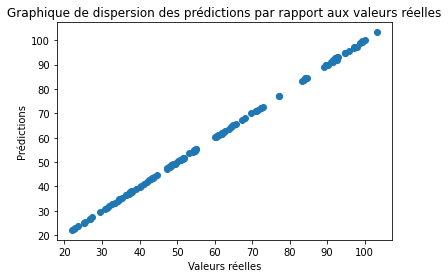

In [75]:
# Graphique de dispersion des prédictions par rapport aux valeurs réelles :
# Affiche les valeurs prédites par le modèle par rapport aux valeurs réelles.
# Permet de visualiser la précision du modèle et d'identifier les tendances.

plt.scatter(y_test, y_pred)
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Graphique de dispersion des prédictions par rapport aux valeurs réelles")
plt.show()

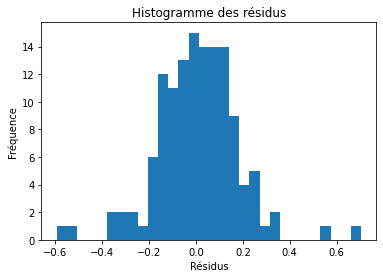

In [76]:
# Histogramme des résidus :
# Montre la distribution des résidus (différences entre les valeurs réelles et les prédictions).
# Utile pour vérifier l'homoscédasticité (homogénéité de la variance des résidus).

residus = y_test - y_pred
plt.hist(residus, bins=30)
plt.xlabel("Résidus")
plt.ylabel("Fréquence")
plt.title("Histogramme des résidus")
plt.show()

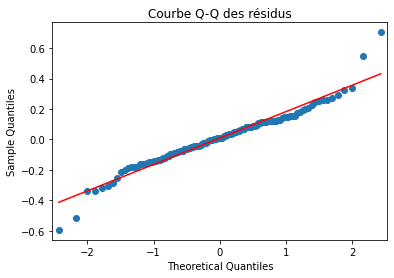

In [77]:
# Courbe Q-Q (Quantile-Quantile) des résidus :
# Compare la distribution des résidus avec une distribution théorique normale.
# Permet d'identifier les déviations de la normalité.

import statsmodels.api as sm

sm.qqplot(residus, line='r')
plt.title("Courbe Q-Q des résidus")
plt.show()

## Retour au problème initial :
On rappelle qu'on voulait initialement pouvoir prédire $\gamma_{t}$ avec $\gamma_{t}$ défini comme le taux de croissance industriel observé à l'instant $t$. On a fait la supposition du modèle suivant :
$ INDPRO = X^{T}\beta + \varepsilon $ avec $ \varepsilon $ un bruit Gaussien.
On a aussi la formule suivante : $ \gamma_{t} = \frac{ INDPRO_{t} - INDPRO_{t-1} }{ INDPRO_{t-1} } \times 100 $
Donc il suffit de savoir prédire $INDPRO$ pour pouvoir prédire $\gamma$, ce qui nous donne :
$ \hat\gamma_{t} = \frac{\hat{INDPRO}_{t} - \hat{INDPRO}_{t-1}}{\hat{INDPRO}_{t-1}} \times 100 $ avec les prédictions de $INDPRO$ que nous avons obtenues grâce à une régression linéaire

In [300]:
DF = df.copy()
DF.head()

,INDPRO,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST
13,24.1298,2391.2,2252.3,18.910,263212.787497,18762.29853,23.3215,22.6512,30.5722,20.1768,...,54.611,20.000,12.502,2.22,2.57,2.13,286.7,7362.0,14063.0,75.5
14,23.9151,2392.8,2253.8,18.993,267039.890455,18831.78084,23.1893,22.5734,30.2240,19.8991,...,54.700,20.001,12.522,2.23,2.59,2.14,287.0,7396.0,14144.0,73.3
15,23.7004,2397.2,2255.4,19.262,259610.179810,18811.03986,23.1100,22.5475,30.2588,19.5057,...,54.540,20.037,12.529,2.24,2.69,2.14,287.8,7456.0,14239.0,71.5
16,23.5125,2405.6,2263.4,19.560,262179.545533,19304.67539,23.1629,22.5734,30.4677,19.4826,...,54.606,20.163,12.555,2.24,2.61,2.14,288.3,7582.0,14413.0,71.5
17,23.4857,2411.7,2269.4,19.166,254056.886617,19016.37565,23.2951,22.7289,30.6418,19.6677,...,54.600,20.154,12.590,2.24,2.64,2.14,289.1,7673.0,14559.0,71.7


In [302]:
DF = DF.iloc[1:,:]

In [303]:
DF.head()

,INDPRO,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,gamma
14,23.9151,2392.8,2253.8,18.993,267039.890455,18831.78084,23.1893,22.5734,30.2240,19.8991,...,20.001,12.522,2.23,2.59,2.14,287.0,7396.0,14144.0,73.3,-0.897759
15,23.7004,2397.2,2255.4,19.262,259610.179810,18811.03986,23.1100,22.5475,30.2588,19.5057,...,20.037,12.529,2.24,2.69,2.14,287.8,7456.0,14239.0,71.5,-0.905892
16,23.5125,2405.6,2263.4,19.560,262179.545533,19304.67539,23.1629,22.5734,30.4677,19.4826,...,20.163,12.555,2.24,2.61,2.14,288.3,7582.0,14413.0,71.5,-0.799149
17,23.4857,2411.7,2269.4,19.166,254056.886617,19016.37565,23.2951,22.7289,30.6418,19.6677,...,20.154,12.590,2.24,2.64,2.14,289.1,7673.0,14559.0,71.7,-0.114112
18,23.1904,2412.8,2268.2,19.161,256224.511174,18990.44941,23.0307,22.4697,30.4329,19.4595,...,20.150,12.614,2.24,2.64,2.14,290.2,7805.0,14816.0,71.2,-1.273372


In [311]:
Indpro_index = pd.DataFrame(y_test).index

In [316]:
INDPRO_test = pd.DataFrame(np.array([y_test,y_pred]).T , index = Indpro_index , columns = ['INDPRO_test' , 'INDPRO_pred'])
INDPRO_test.head()

,INDPRO_test,INDPRO_pred
144,37.1684,37.048801
110,36.3272,36.465371
322,54.5916,54.656009
445,72.3857,72.296318
267,50.9285,50.810961


In [313]:
DF_test = DF.loc[DF.index.isin(INDPRO_test.index)]

In [315]:
DF_test = DF_test.rename(columns={'INDPRO' : 'INDPRO_test' , 'gamma' : 'gamma_test'})
DF_test.head()

,INDPRO_test,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,gamma_test
16,23.5125,2405.6,2263.4,19.560,262179.545533,19304.67539,23.1629,22.5734,30.4677,19.4826,...,20.163,12.555,2.24,2.61,2.14,288.3,7582.0,14413.0,71.5,-0.799149
21,22.8415,2417.6,2268.6,19.274,258252.740753,18846.29954,22.6605,22.2106,30.0847,18.6959,...,20.238,12.695,2.26,2.68,2.16,295.5,7854.0,15282.0,74.0,-1.057724
26,22.0631,2434.1,2269.4,19.183,246917.139955,18551.77749,22.2374,21.7182,29.5624,16.9142,...,20.378,12.774,2.27,2.72,2.16,303.4,7433.0,15216.0,79.6,-0.121923
28,22.6536,2449.2,2288.0,19.431,245507.975856,18415.92402,22.6869,22.1069,30.2588,18.1406,...,20.241,12.806,2.29,2.76,2.18,306.5,7243.0,15055.0,79.0,2.014249
41,25.1766,2605.8,2440.1,20.561,271078.287964,20292.98351,24.9345,24.4394,33.0444,21.5419,...,20.353,13.084,2.38,2.86,2.27,329.3,7106.0,15968.0,86.7,-0.106845


In [317]:
DF_test = pd.concat([DF_test, INDPRO_test], axis=1)
DF_test.head()

,INDPRO_test,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,gamma_test,INDPRO_test,INDPRO_pred
16,23.5125,2405.6,2263.4,19.560,262179.545533,19304.67539,23.1629,22.5734,30.4677,19.4826,...,2.24,2.61,2.14,288.3,7582.0,14413.0,71.5,-0.799149,23.5125,23.589423
21,22.8415,2417.6,2268.6,19.274,258252.740753,18846.29954,22.6605,22.2106,30.0847,18.6959,...,2.26,2.68,2.16,295.5,7854.0,15282.0,74.0,-1.057724,22.8415,22.888026
26,22.0631,2434.1,2269.4,19.183,246917.139955,18551.77749,22.2374,21.7182,29.5624,16.9142,...,2.27,2.72,2.16,303.4,7433.0,15216.0,79.6,-0.121923,22.0631,22.169242
28,22.6536,2449.2,2288.0,19.431,245507.975856,18415.92402,22.6869,22.1069,30.2588,18.1406,...,2.29,2.76,2.18,306.5,7243.0,15055.0,79.0,2.014249,22.6536,22.744491
41,25.1766,2605.8,2440.1,20.561,271078.287964,20292.98351,24.9345,24.4394,33.0444,21.5419,...,2.38,2.86,2.27,329.3,7106.0,15968.0,86.7,-0.106845,25.1766,25.168918


In [318]:
DF_test = DF_test[['INDPRO_test', 'INDPRO_pred'] + [col for col in DF_test.columns if col != 'INDPRO_test' and col != 'INDPRO_pred']]
DF_test.head()

,INDPRO_test,INDPRO_test,INDPRO_pred,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,IPFPNSS,IPFINAL,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,gamma_test
16,23.5125,23.5125,23.589423,2405.6,2263.4,19.560,262179.545533,19304.67539,23.1629,22.5734,...,20.163,12.555,2.24,2.61,2.14,288.3,7582.0,14413.0,71.5,-0.799149
21,22.8415,22.8415,22.888026,2417.6,2268.6,19.274,258252.740753,18846.29954,22.6605,22.2106,...,20.238,12.695,2.26,2.68,2.16,295.5,7854.0,15282.0,74.0,-1.057724
26,22.0631,22.0631,22.169242,2434.1,2269.4,19.183,246917.139955,18551.77749,22.2374,21.7182,...,20.378,12.774,2.27,2.72,2.16,303.4,7433.0,15216.0,79.6,-0.121923
28,22.6536,22.6536,22.744491,2449.2,2288.0,19.431,245507.975856,18415.92402,22.6869,22.1069,...,20.241,12.806,2.29,2.76,2.18,306.5,7243.0,15055.0,79.0,2.014249
41,25.1766,25.1766,25.168918,2605.8,2440.1,20.561,271078.287964,20292.98351,24.9345,24.4394,...,20.353,13.084,2.38,2.86,2.27,329.3,7106.0,15968.0,86.7,-0.106845


In [328]:
DF_test['gamma_pred'] = ((DF_test['INDPRO_pred'].diff())/DF_test['INDPRO_pred'])*100
DF_test = DF_test.iloc[1:,:]
DF_test.head()

,INDPRO_test,INDPRO_test,INDPRO_pred,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,IPFPNSS,IPFINAL,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,gamma_test,gamma_pred
41,25.1766,25.1766,25.168918,2605.8,2440.1,20.561,271078.287964,20292.98351,24.9345,24.4394,...,13.084,2.38,2.86,2.27,329.3,7106.0,15968.0,86.7,-0.106845,9.632621
42,25.1230,25.1230,25.103037,2611.4,2445.4,20.458,268947.678670,20032.68410,24.9609,24.4135,...,13.109,2.37,2.87,2.26,330.7,7242.0,16228.0,87.4,-0.213350,-0.262442
44,25.3914,25.3914,25.385874,2626.5,2457.9,20.583,273713.162118,20476.54126,25.1989,24.6727,...,13.131,2.40,2.90,2.28,333.6,7442.0,16685.0,87.9,0.105941,1.114152
53,26.8945,26.8945,26.774679,2696.4,2522.5,21.213,282715.242375,21018.91812,26.3359,25.7093,...,13.278,2.45,2.96,2.33,353.7,7836.0,17941.0,90.0,1.197643,5.187007
55,26.8676,26.8676,26.782227,2711.1,2537.5,21.529,286976.530244,21421.29330,26.3887,25.8130,...,13.301,2.47,2.99,2.35,357.9,8110.0,18497.0,90.2,-0.399738,0.028186


In [326]:
mean_squared_error(DF_test['gamma_test'], DF_test['gamma_pred'])

6.296050047035476

In [ ]:
# régis t'es un goat
# 1) bonus : pas shuffle et prendre les 80% premières valeurs en train et prédire les 20% dernières psk sinon ça nique le truc
# SINON ON PEUT PAS CALCULER GAMMA PAS POSSIBLE !!!!

#2) calcul de gamma trivial pas de galere HIGIG

#3) FAIS DES PLOTS LES MEME QUE POUR Y